### Text Embeddings and Classifier
##### Patrick Kwon

Due to computational limitations, the size of the dataset was limited to 10% of its original size (random seed: 1)

Packages used:
    Numpy, Pandas, Matplotlib, Gzip, Spacy (en_core_web_md), Keras, Sklearn, Time.
    
Approximated Total Time: 2~3 days

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import spacy
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, LSTM, Embedding, TimeDistributed, Bidirectional, GlobalMaxPool1D, Dropout, merge
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import time

##### Import Dataset

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
df = getDF('reviews_Beauty_5.json.gz')

df.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)

df.user_id = df.user_id.astype('category').cat.codes.values
df.item_id = df.item_id.astype('category').cat.codes.values
# Add IDs for embeddings.
df['user_emb_id'] = df['user_id']
df['item_emb_id'] = df['item_id']

df = df.sample(frac=0.1, random_state = 1)

##### Import Spacy vectors

In [6]:
nlp = spacy.load('en_core_web_md')
nlp.add_pipe(nlp.create_pipe('sentencizer'))
embeddings = nlp.vocab.vectors.data

##### Data preprocessing

In [7]:
X = np.asarray(df['review_summary'])
Y = np.asarray(df['score'] >= 4.0)

X = list(nlp.pipe(X))
X = [[token.vocab.vectors.find(key=token.orth) for token in doc] for doc in X]
length = len(sorted(X ,key=len, reverse=True)[0])
X = np.array([xi+[None]*(length-len(xi)) for xi in X])

Y = Y.astype(int).reshape(-1)

In [8]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores = []
f1scores = []
rocscores = []
true_positive_list = []

##### Classifier Model 1

|    Layer   (type)                             |    Output   Shape       |    Param   #     |
|-----------------------------------------------|-------------------------|------------------|
|    embedding_1   (Embedding)                  |    (None,   30, 300)    |    6000000       |
|    time_distributed_1   (TimeDist (Dense))    |    (None,   30, 64)     |    19200         |
|    bidirectional_1   (Bidirection (LSTM))     |    (None,   128)        |    66048         |
|    dense_2   (Dense)                          |    (None,   1)          |    129           |

Total params: 6,085,377
Trainable params: 85,377
Non-trainable params: 6,000,000

For computational issues, limited the batch_size to 160 and epochs to 5.

Approx. Execution Time: 22min

Metrics: AUC, F1, Precision/Recall, Accuracy, Loss

Most preferred Metric: F1. Since we want to alert the user if there is a discrepancy between the score and the review_summary, we want to be sure that the precision and the recall scores are balanced. Also, the distribution has an uneven distribution between the positives and negatives.

In [9]:
i = 1
for train, test in kfold.split(X, Y):
    print("Split:", i)
    i += 1
    
    start = time.time()
    X_train = X[train]
    Y_train = Y[train]
    X_test = X[test]
    Y_test = Y[test]
    
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=(1/9), random_state=42)
    
    model = Sequential()
    model.add(Embedding(embeddings.shape[0], embeddings.shape[1], 
                        input_length = length, trainable=False, 
                        weights = [embeddings], mask_zero = True))
    model.add(TimeDistributed(Dense(64, use_bias=False)))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2, dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 160, verbose=2,validation_data = (X_dev, Y_dev), shuffle=True)
    end2 = time.time()
    print("Data Analysis Time:", end2-start)
    
    scores = model.evaluate(X_test, Y_test, verbose=2)
    cvscores.append(scores)
    
    pred = model.predict(X_test)
    roc = roc_curve(Y_test, pred)
    rocscores.append(roc)
    
    pred = np.asarray([1 if x[0] >= 0.5 else 0 for x in pred])
    f1 = f1_score(Y_test, pred)
    f1scores.append(f1)
    
    tp = []
    for j in range(len(X_test)):
        if ((Y_test[j] == 1) & (pred[j] >= 0.5)):
            tp.append(test[j])
            
    true_positive_list.append(tp)    
    print("Test accuracy = ", scores[1])

Split: 1
Train on 15879 samples, validate on 1985 samples
Epoch 1/5
 - 32s - loss: 0.4164 - acc: 0.8121 - val_loss: 0.3651 - val_acc: 0.8453
Epoch 2/5
 - 25s - loss: 0.3354 - acc: 0.8574 - val_loss: 0.3445 - val_acc: 0.8474
Epoch 3/5
 - 21s - loss: 0.3186 - acc: 0.8640 - val_loss: 0.3411 - val_acc: 0.8514
Epoch 4/5
 - 24s - loss: 0.3055 - acc: 0.8722 - val_loss: 0.3382 - val_acc: 0.8574
Epoch 5/5
 - 26s - loss: 0.2960 - acc: 0.8751 - val_loss: 0.3300 - val_acc: 0.8564
Data Analysis Time: 151.48531532287598
Test accuracy =  0.8685800604229608
Split: 2
Train on 15879 samples, validate on 1985 samples
Epoch 1/5
 - 24s - loss: 0.4206 - acc: 0.8115 - val_loss: 0.3221 - val_acc: 0.8630
Epoch 2/5
 - 23s - loss: 0.3394 - acc: 0.8532 - val_loss: 0.3017 - val_acc: 0.8751
Epoch 3/5
 - 24s - loss: 0.3242 - acc: 0.8623 - val_loss: 0.2963 - val_acc: 0.8816
Epoch 4/5
 - 22s - loss: 0.3101 - acc: 0.8684 - val_loss: 0.2894 - val_acc: 0.8826
Epoch 5/5
 - 20s - loss: 0.3003 - acc: 0.8763 - val_loss: 0.28

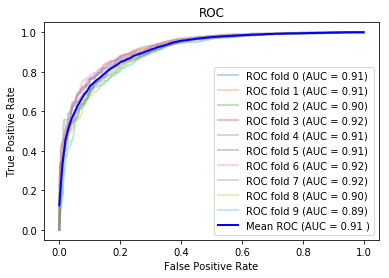

Mean AUC: 0.9086397682269919
Mean F1: 0.91975225946766
Mean Loss: 0.3049643527613366
Mean Accuracy: 0.8730982490754939


In [10]:
tprs = [np.interp(np.linspace(0,1,100), x[0], x[1]) for x in rocscores]
aucs = [auc(x[0], x[1]) for x in rocscores]
for i in range(10):
    plt.plot(rocscores[i][0], rocscores[i][1], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, aucs[i]))
    
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(np.linspace(0,1,100), mean_tpr)
plt.plot(np.linspace(0,1,100), mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("Mean AUC:", mean_auc)
print("Mean F1:", np.mean(f1scores))
print("Mean Loss:", np.mean(cvscores, axis=0)[0])
print("Mean Accuracy:", np.mean(cvscores, axis=0)[1])

##### Classifier Model 2

|    Layer   (type)               |    Output   Shape       |    Param   #    |
|---------------------------------|-------------------------|-----------------|
|    embedding_3   (Embedding)    |    (None,   30, 300)    |    6000000      |
|    lstm_2   (LSTM)              |    (None,   30, 128)    |    219648       |
|    dropout_1   (Dropout)        |    (None,   30, 128)    |    0            |
|    lstm_3   (LSTM)              |    (None,   128)        |    131584       |
|    dropout_2   (Dropout)        |    (None,   128)        |    0            |
|    dense_5   (Dense)            |    (None,   1)          |    129          |

Total params: 6,351,361
Trainable params: 351,361
Non-trainable params: 6,000,000

For computational issues, limited the batch_size to 320 and epochs to 5.

Approx. Execution Time: 706 sec

Metrics: AUC, F1, Accuracy, Loss

In [27]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores2 = []
f1scores2 = []
rocscores2 = []

In [28]:
i = 1
start = time.time()
for train, test in kfold.split(X, Y):
    print("Split:", i)
    i += 1
    
    X_train = X[train]
    Y_train = Y[train]
    X_test = X[test]
    Y_test = Y[test]
    
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=(1/9), random_state=42)
    
    model = Sequential()
    model.add(Embedding(embeddings.shape[0], embeddings.shape[1], 
                        input_length = 30, trainable=False, 
                        weights = [embeddings], mask_zero = True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 320, verbose=2,validation_data = (X_dev, Y_dev), shuffle=True)
    
    scores = model.evaluate(X_test, Y_test, verbose=2)
    cvscores2.append(scores)
    
    pred = model.predict(X_test)
    roc = roc_curve(Y_test, pred)
    rocscores2.append(roc)
    
    pred = np.asarray([1 if x[0] >= 0.5 else 0 for x in pred])
    f1 = f1_score(Y_test, pred)
    f1scores2.append(f1)
    
    print("Test accuracy = ", scores[1])

end2 = time.time()
print("Data Analysis Time:", end2-start)

Split: 1
Train on 15879 samples, validate on 1985 samples
Epoch 1/5
 - 15s - loss: 0.5472 - acc: 0.7660 - val_loss: 0.5339 - val_acc: 0.7748
Epoch 2/5
 - 9s - loss: 0.5385 - acc: 0.7749 - val_loss: 0.5333 - val_acc: 0.7748
Epoch 3/5
 - 9s - loss: 0.5363 - acc: 0.7749 - val_loss: 0.5332 - val_acc: 0.7748
Epoch 4/5
 - 9s - loss: 0.5374 - acc: 0.7749 - val_loss: 0.5335 - val_acc: 0.7748
Epoch 5/5
 - 9s - loss: 0.5280 - acc: 0.7750 - val_loss: 0.4421 - val_acc: 0.7748
Test accuracy =  0.7749244712990937
Split: 2
Train on 15879 samples, validate on 1985 samples
Epoch 1/5
 - 14s - loss: 0.5445 - acc: 0.7652 - val_loss: 0.5161 - val_acc: 0.7894
Epoch 2/5
 - 9s - loss: 0.5394 - acc: 0.7731 - val_loss: 0.5149 - val_acc: 0.7894
Epoch 3/5
 - 9s - loss: 0.5397 - acc: 0.7731 - val_loss: 0.5150 - val_acc: 0.7894
Epoch 4/5
 - 11s - loss: 0.5376 - acc: 0.7731 - val_loss: 0.5156 - val_acc: 0.7894
Epoch 5/5
 - 12s - loss: 0.5377 - acc: 0.7731 - val_loss: 0.5154 - val_acc: 0.7894
Test accuracy =  0.77492

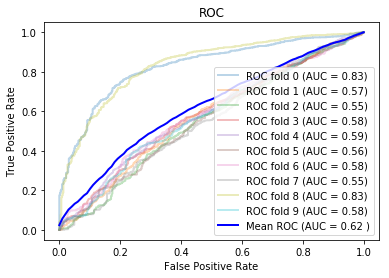

Mean AUC: 0.6224825424733428
Mean F1: 0.8733634275347214
Mean Loss: 0.5119116600492131
Mean Accuracy: 0.7785408989725839


In [29]:
tprs = [np.interp(np.linspace(0,1,100), x[0], x[1]) for x in rocscores2]
aucs = [auc(x[0], x[1]) for x in rocscores2]
for i in range(10):
    plt.plot(rocscores2[i][0], rocscores2[i][1], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, aucs[i]))
    
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(np.linspace(0,1,100), mean_tpr)
plt.plot(np.linspace(0,1,100), mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print("Mean AUC:", mean_auc)
print("Mean F1:", np.mean(f1scores2))
print("Mean Loss:", np.mean(cvscores2, axis=0)[0])
print("Mean Accuracy:", np.mean(cvscores2, axis=0)[1])

Model 1 has a better performance than Model 2 in all possible areas (F1, AUC, Loss, Accuracy)

##### Word Cloud of true positive results

The true positive results for model 1 were collected and were used to create a word cloud.
Since words like "Great", "Love", "Best" seems to be the most frequent words, it seems that this model is doing a reasonable job.

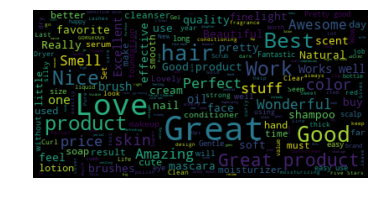

In [26]:
wordstr = list(df.iloc[true_positive_list[1]]['review_summary'])
wordstr2 = " ".join(wordstr)

from wordcloud import WordCloud

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(wordstr2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#wordlist = [w.split() for w in wordstr]
#wordlist = [item for sl in wordlist for item in sl]

### Recommendation System

In [30]:
X = np.asarray(df[['user_id', 'item_id']])
Y = np.asarray(df['score'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=(1/9), random_state=42)

In [31]:
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, dev = train_test_split(df, test_size=(1/9), random_state=42)

X_train = [np.array([[element] for element in train.user_id]), 
           np.array([[element] for element in train.item_id])]
Y_train = np.array([[element] for element in train.score])

X_dev = [np.array([[element] for element in dev.user_id]), 
         np.array([[element] for element in dev.item_id])]
Y_dev = np.array([[element] for element in dev.score])

X_test = [np.array([[element] for element in test.user_id]), 
         np.array([[element] for element in test.item_id])]
Y_test = np.array([[element] for element in test.score])

In [50]:
embed_list = [10, 50, 100]
embed = embed[0]
n_user=len(df['user_id'].unique())
n_item=len(df['item_id'].unique())

#%%
user_input = Input(shape=[1], name='user_input')
user_embed = Embedding(n_user, embed, name='user_embed')(user_input)
user_flat = Flatten(name='user_flat')(user_embed)
#user_drop = Dropout(0.2, name='user_drop')(user_flat)

item_input = Input(shape=[1], name='item_input')
item_embed = Embedding(n_item, embed, name='item_embed')(item_input)
item_flat = Flatten(name='item_flat')(item_embed)
#item_drop = Dropout(0.2, name='item_drop')(item_flat)

prod = merge.concatenate([user_flat, item_flat], name='DotProduct')
prod = Dropout(0.5)(prod)
x = Dense(64, activation='relu')(prod)
y = Dense(1)(x)

model = Model([user_input, item_input], y)

model.compile(loss='mae', optimizer='adam', metrics=['acc'])

TypeError: 'int' object is not subscriptable

In [51]:
model.fit(X_train, Y_train, batch_size=20, epochs=10, 
           validation_data = (X_dev, Y_dev), shuffle=True, verbose=2)

pred = model.predict(X_test)
pred = np.round(pred)

loss, acc = model.evaluate(X_test, Y_test)
print("Loss: ", loss)
print("Accuracy: ", acc)

Train on 17644 samples, validate on 2206 samples
Epoch 1/10
 - 5s - loss: 0.4564 - acc: 0.7062 - val_loss: 0.9351 - val_acc: 0.4973
Epoch 2/10
 - 6s - loss: 0.4560 - acc: 0.7106 - val_loss: 0.9436 - val_acc: 0.4991
Epoch 3/10
 - 8s - loss: 0.4536 - acc: 0.7132 - val_loss: 0.9434 - val_acc: 0.5009
Epoch 4/10
 - 6s - loss: 0.4574 - acc: 0.7085 - val_loss: 0.9344 - val_acc: 0.4973
Epoch 5/10
 - 5s - loss: 0.4525 - acc: 0.7125 - val_loss: 0.9425 - val_acc: 0.5023
Epoch 6/10
 - 6s - loss: 0.4559 - acc: 0.7111 - val_loss: 0.9370 - val_acc: 0.4995
Epoch 7/10
 - 6s - loss: 0.4557 - acc: 0.7096 - val_loss: 0.9415 - val_acc: 0.5014
Epoch 8/10
 - 6s - loss: 0.4517 - acc: 0.7128 - val_loss: 0.9471 - val_acc: 0.4927
Epoch 9/10
 - 7s - loss: 0.4512 - acc: 0.7165 - val_loss: 0.9400 - val_acc: 0.5000
Epoch 10/10
 - 6s - loss: 0.4508 - acc: 0.7149 - val_loss: 0.9318 - val_acc: 0.5063
1985/1985 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 117us/step
Loss:  0.929155202956

Embedding size=10 seems to work best.